### Copyright (C) 2022 Sobhan Moradian Daghigh
#### Date: 2/192022

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

### Load Datas

In [60]:
def load_datasets(path):
    datasets = []
    names = []
    print('Loading the datasets..\n')
    for root, dirs, files in os.walk(path):
        for i, file in enumerate(files):
            name = file.split('.')[0]
            if name == 'rings':
                data = pd.read_csv(os.path.join(root, file), names=['target', 'x1', 'x2', 'x3'], sep='\t')
                data['label'] = data.iloc[:, 0]
                data = data.drop('target', axis=1)
                datasets.append(data)
            else:
                datasets.append(pd.read_csv(os.path.join(root, file), names=['x1', 'x2', 'label'], sep='\t'))
            print(' |_  {}. {} loaded'.format(i + 1, name))
            names.append(name)
    return datasets, names

In [61]:
datasets, names = load_datasets('./data/3')

Loading the datasets..

 |_  1. Compound loaded
 |_  2. D31 loaded
 |_  3. pathbased loaded
 |_  4. rings loaded
 |_  5. spiral loaded


In [62]:
datasets[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      399 non-null    float64
 1   x2      399 non-null    float64
 2   label   399 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 9.5 KB


In [79]:
def plotter(datasets, names, labels=None):
    for i, (data, name) in enumerate(zip(datasets, names)):
        if labels is None:
            label = data.iloc[:, -1]
        else:
            label = labels[i]
            
        if name == 'rings':
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(projection='3d')
            ax.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], c=label)
        else:
            fig = plt.figure(figsize=(10, 7))
            plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=label)

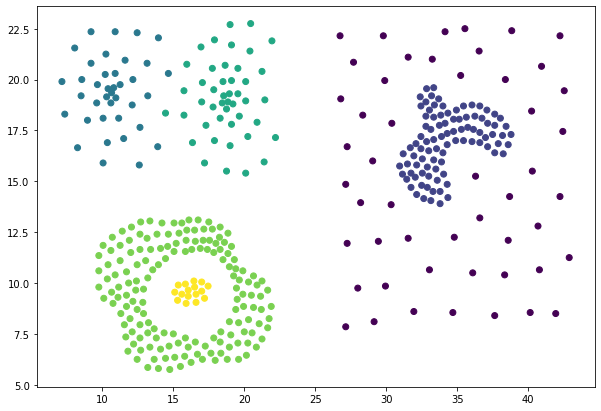

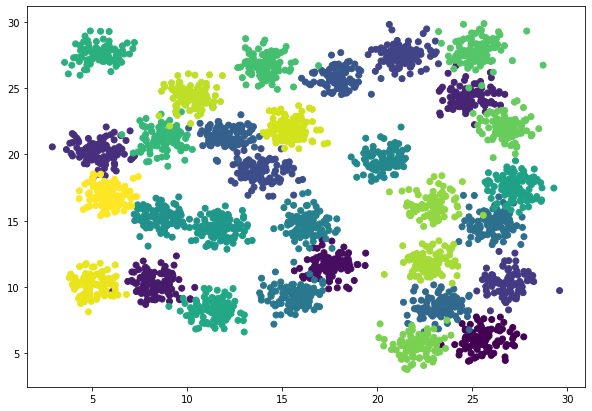

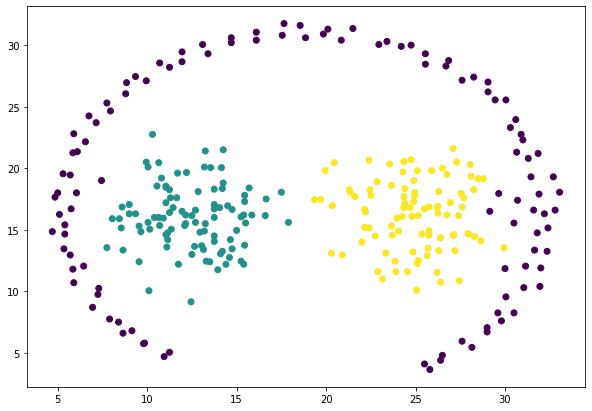

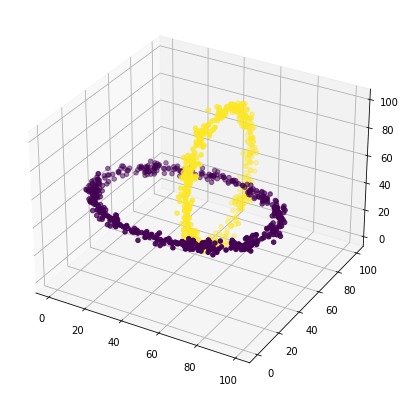

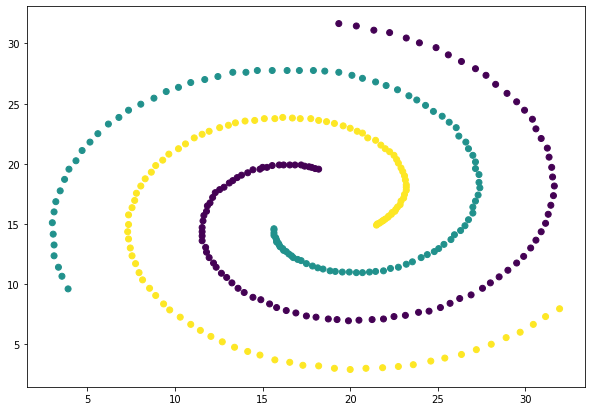

In [80]:
plotter(datasets, names)

In [81]:
def purity_score(y_true, y_pred):
    confusion_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.divide(np.sum(np.amax(confusion_matrix, axis=0)), np.sum(confusion_matrix))

In [82]:
def get_neighbors(datas, index, eps):
    neighbors = []
    
    temp = np.linalg.norm(datas - datas.iloc[index, :], axis=1)

    for i, ele in enumerate(temp):
        if ele < eps:
            neighbors.append(i)
        
    return neighbors

In [83]:
def keep_going_exploration(datas, labels, pnt_index, neighbors, cluster_id, eps, min_pts):
    idx = 0
    while idx in range(len(neighbors)):
        if labels[neighbors[idx]] == -1:
            labels[neighbors[idx]] == cluster_id
            
        elif labels[neighbors[idx]] == 0:
            labels[neighbors[idx]] = cluster_id
            neighbor_pts = get_neighbors(datas, index=neighbors[idx], eps=eps)
            if len(neighbor_pts) >= min_pts:
                neighbors += neighbor_pts
        idx += 1
        
    return labels

In [84]:
def dbscan(datas, eps, min_pts):
    labels = [0] * len(datas)
    cluster_id = 0
    for i in range(len(datas)):
        if labels[i] == 0:
            neighbor_pts = get_neighbors(datas, index=i, eps=eps)
            if len(neighbor_pts) < min_pts:
                labels[i] == -1
            else:
                cluster_id += 1
                labels[i] == cluster_id
                labels = keep_going_exploration(datas, labels, i, neighbor_pts, cluster_id, eps, min_pts)
    return labels

In [85]:
def grid_search(data, tuned_parameters):
    purities = []
    params = []
    for eps in tuned_parameters.get('eps'):
        for min_pts in tuned_parameters.get('min_pts'):
            predictions = dbscan(datas=data.iloc[:, :-1], eps=eps, min_pts=min_pts)
            purity = purity_score(data.iloc[:, -1], predictions)
            purities.append(purity)
            params.append([eps, min_pts])
            
    best_idx = np.argmax(purities)
    best_params = params[best_idx]
    return best_params

In [108]:
labels_list = []
tuned_parameters = {'eps': np.arange(0.01, 5, 0.1), 'min_pts': np.arange(2, 4)}
print('Purity:')
print('(eps - min_pts)')
for i, data in enumerate(datasets):
    eps, min_pts = grid_search(data, tuned_parameters)
    labels_list.append(dbscan(datas=data.iloc[:, :-1], eps=eps, min_pts=min_pts))
    print('  |_ {}: {}'.format(names[i], round(purity_score(data.iloc[:, -1], labels_list[i]), 2)))
    print('     ({} - {})'.format(round(eps, 2), min_pts))

Purity:
(eps - min_pts)
  |_ Compound: 0.98
     (1.51 - 2)
  |_ D31: 0.89
     (0.31 - 2)
  |_ pathbased: 0.98
     (1.31 - 2)
  |_ rings: 1.0
     (4.61 - 2)
  |_ spiral: 1.0
     (1.11 - 2)


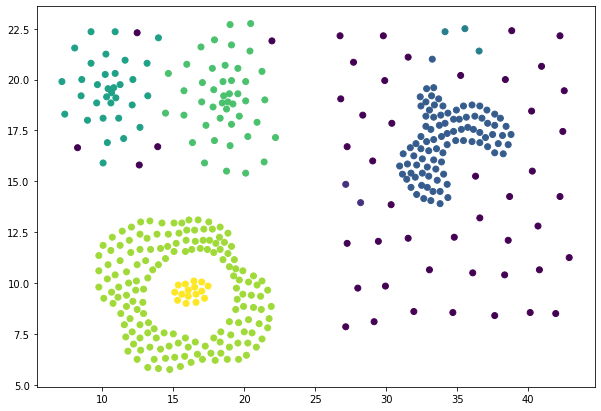

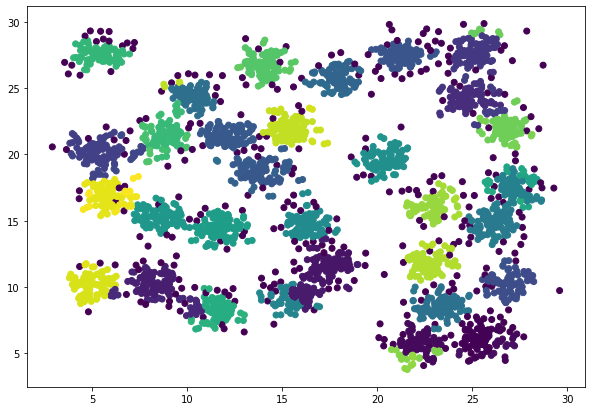

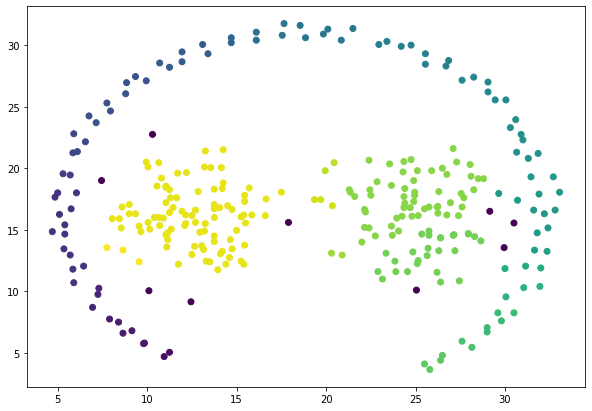

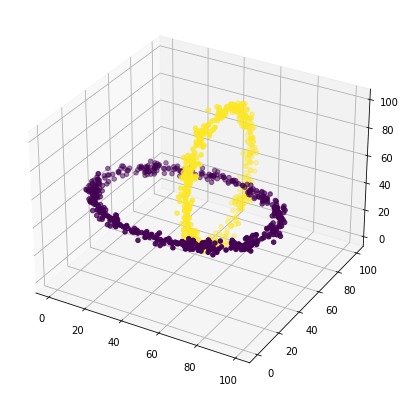

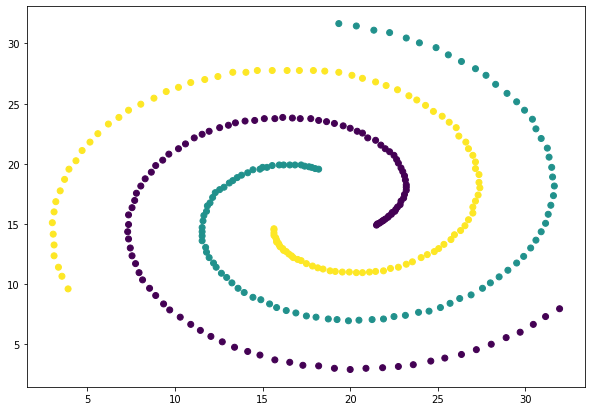

In [109]:
plotter(datasets, names, labels_list)

In [24]:
# Garbage:

In [20]:
# tuned_parameters = {'eps': np.arange(0.01, 2.5, 0.1), 'min_pts': np.arange(2, 6)}
# print('Purity:')
# eps, min_pts = grid_search(datasets[3], tuned_parameters)
# print(eps, min_pts)
# oo = dbscan(datas=datasets[3].iloc[:, :-1], eps=eps, min_pts=min_pts)
# print('  |_ {}: {}'.format(names[3], round(purity_score(datasets[3].iloc[:, -1], oo), 2)))

In [7]:
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=2)
# nbrs = neigh.fit(datasets[4].iloc[:, :-1])
# distances, indices = nbrs.kneighbors(datasets[4].iloc[:, :-1])

In [23]:
# fig = plt.figure(figsize=(10, 7))
# distances1 = np.sort(distances, axis=0)
# distances2 = distances1[:, 1]
# plt.plot(distances2)
# plt.plot([1.5] * len(distances2))